Edges and Weights:
('Warehouse', 'C2', {'weight': 3})
('Warehouse', 'C1', {'weight': 2})
('Warehouse', 'C5', {'weight': 9})
('Warehouse', 'C10', {'weight': 2})
('Warehouse', 'C7', {'weight': 10})
('C1', 'C2', {'weight': 4})
('C1', 'C9', {'weight': 9})
('C1', 'C7', {'weight': 8})
('C2', 'C7', {'weight': 1})
('C2', 'C4', {'weight': 3})
('C3', 'C7', {'weight': 5})
('C5', 'C8', {'weight': 3})
('C6', 'C10', {'weight': 6})
('C7', 'C9', {'weight': 1})


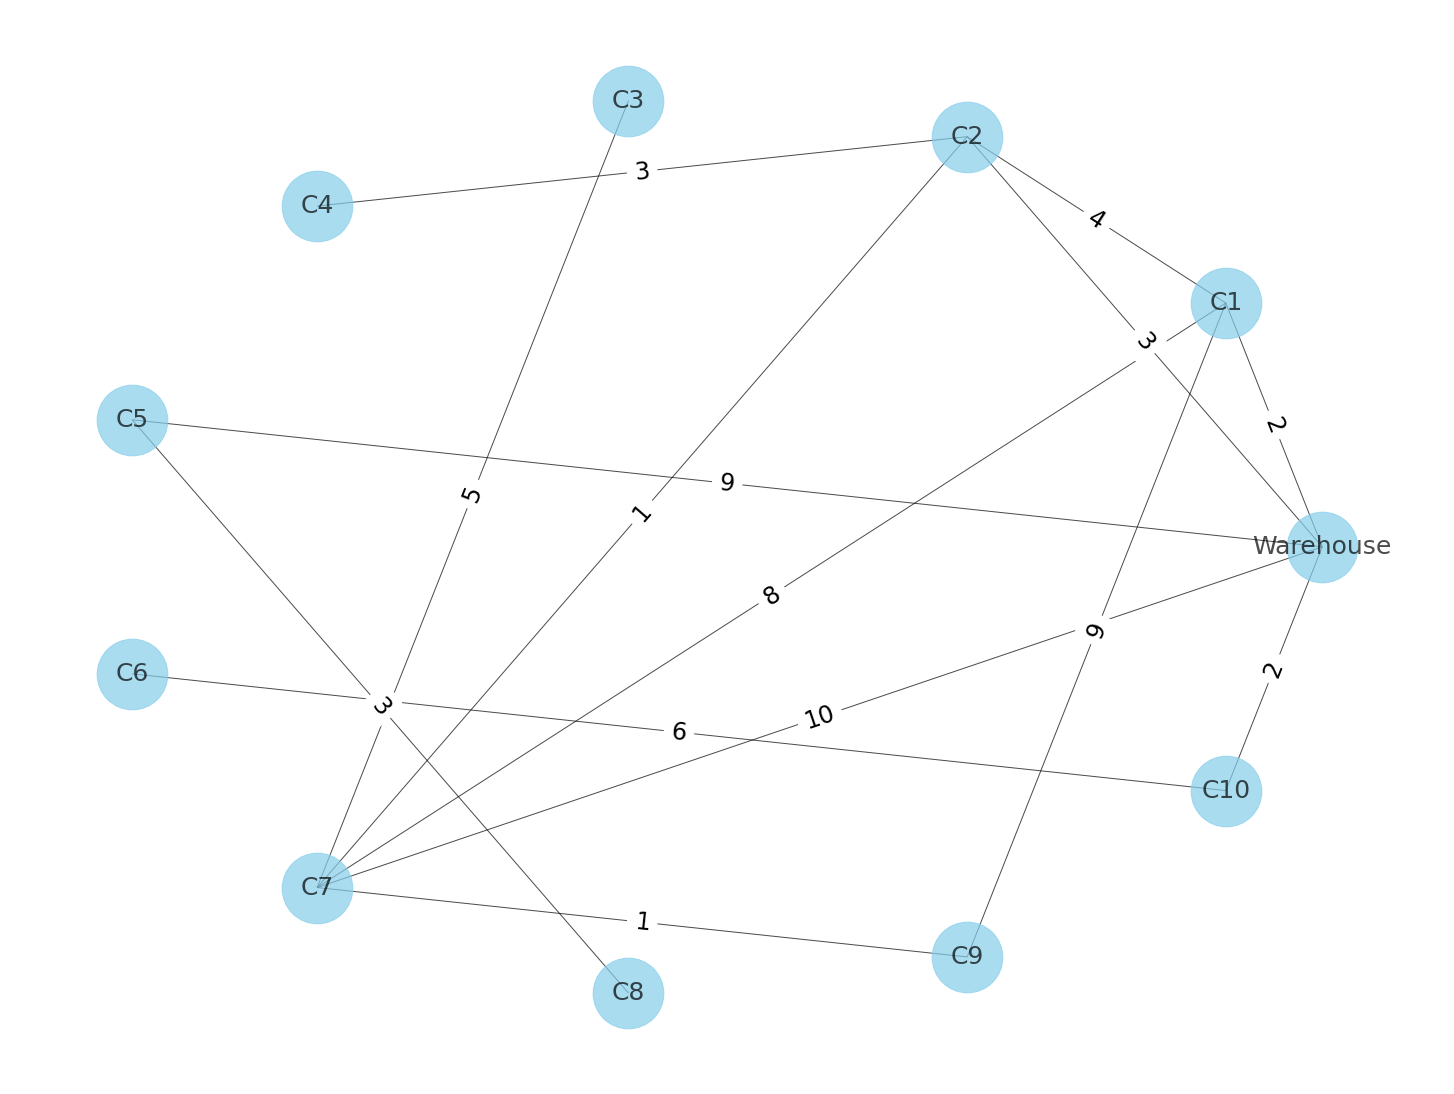

Enter the number of orders: 1
Enter the consumer: C4
Enter the quantity (1 to 50): 50

Delivering orders using CSP solution:

Orders delivered successfully!


Delivering orders using heuristic solution:
Delivering 50 units to C4 via path: ['Warehouse', 'C2', 'C4'] with cost: 6
Truck capacity remaining: 0 units

All orders delivered successfully!



In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def create_graph(seed=None):
    if seed is not None:
        random.seed(seed)

    G = nx.Graph()

    # Add warehouse node
    G.add_node('Warehouse')

    # Add consumer nodes
    consumers = ['C{}'.format(i) for i in range(1, 11)]
    G.add_nodes_from(consumers)

    # Connect warehouse to five consumers directly
    connected_consumers = random.sample(consumers, 5)
    for consumer in connected_consumers:
        weight = random.randint(1, 10)
        G.add_edge('Warehouse', consumer, weight=weight)

    # Connect remaining consumers to each other and to the connected consumers
    for i in range(5):
        consumer1 = random.choice(consumers)
        consumer2 = random.choice(connected_consumers)
        weight = random.randint(1, 10)
        G.add_edge(consumer1, consumer2, weight=weight)

    for c in consumers:
        flag = 0
        for edge in G.edges(data=True):
            if c in edge:
                flag = 1
                break
        if not flag:
            G.add_edge(c, random.choice(connected_consumers), weight=random.randint(1, 10))

    return G

def dijkstra_path(graph, start, end):
    queue = [(0, start, [])]
    visited = set()

    while queue:
        queue.sort()  # Sort the queue based on cost
        (cost, node, path) = queue.pop(0)

        if node not in visited:
            visited.add(node)
            path = path + [node]

            if node == end:
                return cost, path  # Return both cost and path

            for neighbor, data in graph[node].items():
                neighbor_cost = data['weight']
                queue.append((cost + neighbor_cost, neighbor, path))

    return float('inf'), []  # Return infinity if no path is found

def print_and_plot_graph(G):
    # Print edges and their weights
    print("Edges and Weights:")
    for edge in G.edges(data=True):
        print(edge)

    # Draw and display the graph
    plt.figure(figsize=(20, 15))
    pos = nx.circular_layout(G)
    labels = nx.get_edge_attributes(G, 'weight')
    
    # font size of edge weights 
    font_size = 24
    
    nx.draw(G, pos, with_labels=True, node_size=5000, font_size=25, font_color='black', node_color='skyblue', edge_color='black', linewidths=1, alpha=0.7, arrowsize=100)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=font_size)
    plt.show()

class DeliveryCSP:
    def __init__(self, graph, order_queue):
        self.graph = graph
        self.order_queue = order_queue
        self.variables = [order['consumer'] for order in order_queue]
        self.domains = {consumer: [0, 1] for consumer in self.variables}  # Binary domain (0: not delivered, 1: delivered)
        self.constraints = {consumer: self.get_constraints(consumer) for consumer in self.variables}
        self.solution = None

    def get_constraints(self, consumer):
        def is_valid_assignment(assignment):
            # Check if the total quantity delivered to the current consumer does not exceed the truck capacity
            total_quantity = sum(assignment[other_consumer] for other_consumer in assignment if other_consumer != consumer)
            return total_quantity + assignment.get(consumer, 0) <= 50

        return is_valid_assignment
   
    def solve(self):
        assignment = {}
        self.solution = self.backtrack(assignment)
        return self.solution

    def backtrack(self, assignment):
        if len(assignment) == len(self.variables):
            return assignment

        var = self.select_unassigned_variable(assignment)
        for value in self.order_domain_values(var, assignment):
            if self.is_consistent(var, value, assignment):
                assignment[var] = value
                result = self.backtrack(assignment)
                if result is not None:
                    return result
                del assignment[var]
        return None

    def select_unassigned_variable(self, assignment):
        unassigned_vars = [var for var in self.variables if var not in assignment]
        return min(unassigned_vars, key=lambda var: len(self.domains[var]))

    def order_domain_values(self, var, assignment):
        return self.domains[var]

    def is_consistent(self, var, value, assignment):
        constraint_func = self.constraints[var]
        return constraint_func(assignment)

    def deliver_orders_csp(self):
        if self.solution is not None:
            print("\nDelivering orders using CSP solution:")
            for consumer, value in self.solution.items():
                if value == 1:
                    print(f"Delivering order to {consumer}")
            print("\nOrders delivered successfully!\n")
        else:
            print("\nNo valid CSP solution found.")

def deliver_orders(graph, orders, use_csp=True):
    if use_csp:
        delivery_csp = DeliveryCSP(graph, orders)
        delivery_csp.solve()
        delivery_csp.deliver_orders_csp()
    else:
        print("\nDelivering orders using heuristic solution:")
        current_location = 'Warehouse'
        truck_capacity = 50

        order_queue_copy = orders.copy()  # Create a copy of the order queue to avoid modifying the original

        while order_queue_copy:
            current_order = order_queue_copy.pop(0)
            consumer = current_order['consumer']
            quantity = current_order['quantity']

            # Find the optimal path to the consumer
            cost_to_consumer, path_to_consumer = dijkstra_path(graph, current_location, consumer)

            # Check if the truck needs to refill at the warehouse if the warehouse is part of the optimal path
            if 'Warehouse' in path_to_consumer[1:]:
                cost = cost_to_consumer
                # Deliver the order
                print(f"Delivering {quantity} units to {consumer} via path: {path_to_consumer} with cost: {cost}")
                print(f"The truck was refilled to its maximum capacity at the warehouse since it is present on the way.")
                truck_capacity = 50
                truck_capacity -= quantity
            else:
                if quantity > truck_capacity:
                    print(f"Truck does not have sufficient capacity to fulfill the order for {consumer}. Refilling at the warehouse.")
                    cost_to_warehouse, path_to_warehouse = dijkstra_path(graph, current_location, 'Warehouse')
                    cost_to_consumer, path_to_consumer = dijkstra_path(graph, 'Warehouse', consumer)
    
                    cost = cost_to_warehouse + cost_to_consumer
                    path_to_consumer = path_to_warehouse + path_to_consumer[1:]  

                    truck_capacity = 50
                    print(f"Delivering {quantity} units to {consumer} via path: {path_to_consumer} with cost: {cost}")
                    truck_capacity -= quantity
                else:
    # Check if there is a consumer in the path that is part of the next 3 consumers to be delivered
                    next_consumers = [order['consumer'] for order in order_queue_copy[:3]]
                    overlapping_consumers = set(path_to_consumer) & set(next_consumers)

                    if overlapping_consumers and truck_capacity >= quantity:
                        next_consumer = overlapping_consumers.pop()
                        next_consumer_quantity = next(order['quantity'] for order in order_queue_copy if order['consumer'] == next_consumer)

        # Check if the truck can fulfill the order for the next consumer as well
                        if quantity + next_consumer_quantity <= truck_capacity:
            # Deliver to both consumers
                            order_queue_copy = [order for order in order_queue_copy if order['consumer'] not in (consumer, next_consumer)]
            
                            cost = cost_to_consumer
            
                            print(f"Delivering {quantity} units to {consumer} and {next_consumer_quantity} units to {next_consumer} via path: {path_to_consumer} with cost: {cost}")
                            truck_capacity -= quantity + next_consumer_quantity
                        else:
            # Deliver only to the current consumer
                            print(f"Delivering {quantity} units to {consumer} via path: {path_to_consumer} with cost: {cost_to_consumer}")
                            truck_capacity -= quantity
                    else:
        # Deliver only to the current consumer
                        print(f"Delivering {quantity} units to {consumer} via path: {path_to_consumer} with cost: {cost_to_consumer}")
                        truck_capacity -= quantity
                     
            # Update the current location
            current_location = consumer

            # Print the quantity left in the truck
            print(f"Truck capacity remaining: {truck_capacity} units\n")

        print("All orders delivered successfully!\n")


# Create and print the graph with a specific seed (change seed as needed)
graph = create_graph(seed=42)
print_and_plot_graph(graph)

# Take input for the order queue
order_queue = []
num_orders = int(input("Enter the number of orders: "))

for _ in range(num_orders):
    consumer = input("Enter the consumer: ")
    quantity = int(input("Enter the quantity (1 to 50): "))

    # Check if the quantity is within the valid range (1 to 50)
    if 1 <= quantity <= 50:
        order_queue.append({'consumer': consumer, 'quantity': quantity})
    else:
        print(f"Invalid quantity ({quantity}). Quantity should be between 1 and 50. Skipping order for {consumer}.\n")


# Deliver orders using CSP and heuristic methods
deliver_orders(graph, order_queue, use_csp=True)
deliver_orders(graph, order_queue, use_csp=False)
